In [1]:
%matplotlib inline
import numpy as np
import cvxpy as cvx
import matplotlib.pyplot as plt
import seaborn

np.random.seed(0)

In [2]:
import functools
@functools.total_ordering
class Classifier:
    def __eq__(self, other):
        return self.loss == other.loss
    
    def __lt__(self, other):
        return self.loss < other.loss
    
    def __str__(self):
        return 'loss: {}\nw: {}\nb: {}'.format(self.loss, np.squeeze(self.w), self.b)
    
    def classify(self, x):
        score = x.dot(self.w) + self.b
        y = np.sign(score)
        y[np.abs(score) < self.d] = 0
        
        return np.asarray(y)

class RejectSVM(Classifier):
    def __init__(self, d):
        assert(0 <= d <= 0.5)
        self.d = d
    
    def fit(self, x, y):
        assert(np.all(np.logical_or(y == 1, y == -1)))
        assert(x.shape[0] == y.shape[0])
        
        num_samples, num_features = x.shape
        d = self.d
        
        w = cvx.Variable(num_features)
        b = cvx.Variable()
        xi = cvx.Variable(num_samples)
        gamma = cvx.Variable(num_samples)

        loss = cvx.sum_squares(w) + cvx.sum_entries(xi + (1 - 2 * d) / d * gamma ) / num_samples
        constrains = [xi >= 0, 
                      gamma >= 0, 
                      xi >= 1 - cvx.mul_elemwise(y, x * w + b), 
                      gamma >= - cvx.mul_elemwise(y, x * w + b)]
        problem = cvx.Problem(cvx.Minimize(loss), constrains)
        result = problem.solve()
        
        self.w = np.asarray(w.value)
        self.b = b.value
        self.xi = np.asarray(xi.value)
        self.gamma = np.asarray(gamma.value)
        self.loss = loss.value
        
        return result


class MinRel(Classifier):
    def __init__(self, d, w, xi, gamma, j):
        self.d = d
        self.w = w
        self.xi = xi
        self.gamma = gamma
        self.j = j
        
    def fit(self, x, y):
        assert(np.all(np.logical_or(y == 1, y == -1)))
        assert(x.shape[0] == y.shape[0])
        
        num_samples, num_features = x.shape
        d = self.d
        j = self.j
        
        w = cvx.Variable(num_features)
        b = cvx.Variable()
        xi = cvx.Variable(num_samples)
        gamma = cvx.Variable(num_samples)

        loss = cvx.abs(w[j])
        constrains = [xi >= 0, 
                      gamma >= 0, 
                      xi >= 1 - cvx.mul_elemwise(y, x * w + b), 
                      gamma >= - cvx.mul_elemwise(y, x * w + b), 
                      cvx.norm(w, p=1) <= np.linalg.norm(self.w, ord=1), 
                      cvx.sum_entries(xi + (1 - 2 * d) / d * gamma) <= np.sum(self.xi + (1 - 2 * d) / d * self.gamma)]
        problem = cvx.Problem(cvx.Minimize(loss), constrains)
        result = problem.solve()

        self.w = np.asarray(w.value)
        self.b = b.value
        self.xi = np.asarray(xi.value)
        self.gamma = np.asarray(gamma.value)
        self.loss = loss.value
        
        return result
    

class MaxRelPos(Classifier):
    def __init__(self, d, w, xi, gamma, j):
        self.d = d
        self.w = w
        self.xi = xi
        self.gamma = gamma
        self.j = j
        
    def fit(self, x, y):
        assert(np.all(np.logical_or(y == 1, y == -1)))
        assert(x.shape[0] == y.shape[0])
        
        num_samples, num_features = x.shape
        d = self.d
        j = self.j
        
        w = cvx.Variable(num_features)
        b = cvx.Variable()
        xi = cvx.Variable(num_samples)
        gamma = cvx.Variable(num_samples)

        loss = w[j]
        constrains = [xi >= 0, 
                      gamma >= 0, 
                      xi >= 1 - cvx.mul_elemwise(y, x * w + b), 
                      gamma >= - cvx.mul_elemwise(y, x * w + b), 
                      cvx.norm(w, p=1) <= np.linalg.norm(self.w, ord=1), 
                      cvx.sum_entries(xi + (1 - 2 * d) / d * gamma) <= np.sum(self.xi + (1 - 2 * d) / d * self.gamma)]
        problem = cvx.Problem(cvx.Maximize(loss), constrains)
        result = problem.solve()

        self.w = np.asarray(w.value)
        self.b = b.value
        self.xi = np.asarray(xi.value)
        self.gamma = np.asarray(gamma.value)
        self.loss = loss.value
        
        return result
    

class MaxRelNeg(Classifier):
    def __init__(self, d, w, xi, gamma, j):
        self.d = d
        self.w = w
        self.xi = xi
        self.gamma = gamma
        self.j = j
        
    def fit(self, x, y):
        assert(np.all(np.logical_or(y == 1, y == -1)))
        assert(x.shape[0] == y.shape[0])
        
        num_samples, num_features = x.shape
        d = self.d
        j = self.j
        
        w = cvx.Variable(num_features)
        b = cvx.Variable()
        xi = cvx.Variable(num_samples)
        gamma = cvx.Variable(num_samples)

        loss = - w[j]
        constrains = [xi >= 0, 
                      gamma >= 0, 
                      xi >= 1 - cvx.mul_elemwise(y, x * w + b), 
                      gamma >= - cvx.mul_elemwise(y, x * w + b), 
                      cvx.norm(w, p=1) <= np.linalg.norm(self.w, ord=1), 
                      cvx.sum_entries(xi + (1 - 2 * d) / d * gamma) <= np.sum(self.xi + (1 - 2 * d) / d * self.gamma)]
        problem = cvx.Problem(cvx.Maximize(loss), constrains)
        result = problem.solve()

        self.w = np.asarray(w.value)
        self.b = b.value
        self.xi = np.asarray(xi.value)
        self.gamma = np.asarray(gamma.value)
        self.loss = loss.value
        
        return result
    

In [3]:
def calculate_hyperplane(w, b, lim):
    x_hyperplane = np.linspace(lim[0], lim[1])
    #w[1] = w[1] if w[1] > 1e-4 else 1e-4
    y_hyperplane = (b - w[0] * x_hyperplane) / w[1]
    return x_hyperplane, y_hyperplane

def visualize(x, y, d=0.5, j=0):
    fig = plt.figure()

    svm = RejectSVM(d)
    svm.fit(x, y)
    y_est = svm.classify(x)

    ax = fig.add_subplot(221)
    ax.set_title('Reject SVM')
    ax.scatter(x[:, 0], x[:, 1], c=y_est)
    ax.set_aspect('equal')
    x_lim = ax.get_xlim()
    y_lim = ax.get_ylim()
    x_hyp, y_hyp = calculate_hyperplane(svm.w, svm.b, x_lim)
    ax.plot(x_hyp, y_hyp)
    ax.set_xlim(x_lim)
    ax.set_ylim(y_lim)
    
    min_rel = MinRel(d, svm.w, svm.xi, svm.gamma, j)
    min_rel.fit(x, y)

    y_est = min_rel.classify(x)

    ax = fig.add_subplot(222)
    ax.set_title('Min Rel')
    ax.scatter(x[:, 0], x[:, 1], c=y_est)
    ax.set_aspect('equal')
    x_lim = ax.get_xlim()
    y_lim = ax.get_ylim()
    x_hyp, y_hyp = calculate_hyperplane(min_rel.w, min_rel.b, x_lim)
    ax.plot(x_hyp, y_hyp)
    ax.set_xlim(x_lim)
    ax.set_ylim(y_lim)
    
    max_rel_pos = MaxRelPos(d, svm.w, svm.xi, svm.gamma, j)
    max_rel_pos.fit(x, y)

    y_est = max_rel_pos.classify(x)

    ax = fig.add_subplot(223)
    ax.set_title('Max Rel Pos')
    ax.scatter(x[:, 0], x[:, 1], c=y_est)
    ax.set_aspect('equal')
    x_lim = ax.get_xlim()
    y_lim = ax.get_ylim()
    x_hyp, y_hyp = calculate_hyperplane(max_rel_pos.w, max_rel_pos.b, x_lim)
    ax.plot(x_hyp, y_hyp)
    ax.set_xlim(x_lim)
    ax.set_ylim(y_lim)
    
    max_rel_neg = MaxRelNeg(d, svm.w, svm.xi, svm.gamma, j)
    max_rel_neg.fit(x, y)

    y_est = max_rel_neg.classify(x)

    ax = fig.add_subplot(224)
    ax.set_title('Max Rel Neg')
    ax.scatter(x[:, 0], x[:, 1], c=y_est)
    ax.set_aspect('equal')
    x_lim = ax.get_xlim()
    y_lim = ax.get_ylim()
    x_hyp, y_hyp = calculate_hyperplane(max_rel_neg.w, max_rel_neg.b, x_lim)
    ax.plot(x_hyp, y_hyp)
    ax.set_xlim(x_lim)
    ax.set_ylim(y_lim)
    
    print('Winner:', 'Max Rel Pos' if max_rel_pos > max_rel_neg else 'Max Rel Neg')

Winner: Max Rel Pos


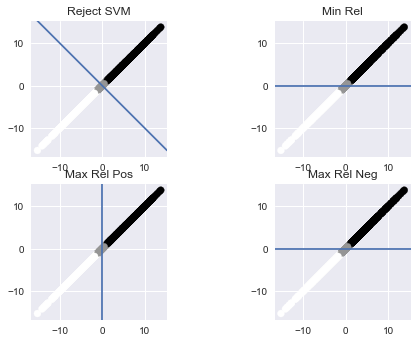

In [4]:
num_samples = 1000
num_features = 2
w_true = np.random.randn(num_features, 1)
b_true = 0
#x = np.random.normal(0, 5, size=(num_samples, num_features))
x1 = np.random.normal(0, 5, size=(num_samples, 1))
x = np.concatenate((x1, x1), axis=1)
y = np.sign(x.dot(w_true) + b_true + np.random.normal(0, 1, size=(num_samples, 1)))

visualize(x, y)